This script is meant to be a platform for testing out adding a masking utility to the Halpha load_data script.  

In the load_data script, it will print out images of the original data and then the mask used - really only the central pixels of the galaxy need to be masked.  Since the data files are ridiculously big, I think I'll just do a cutout so we can actually see what pixels will be masked.

Is there a way to identify the galaxies inside the FOV cutout?  Since we are not doing a rotational transform on the cutout, I think that there should be a straightforward way to go from the total size box coords to the smaller size box coords without too much trouble (might need to add printing info about the lower left coord of the box).

In [22]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology
from skimage import morphology as skimagemorphology

import get_halpha_SB

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%matplotlib inline

machine = 'coho'

In [2]:
if machine == 'chinook':
    homedir = '/Users/lokhorst/Desktop/PipelineTesting/'
if machine == 'coho':
    homedir = '/Users/deblokhorst/Desktop/tmp/'

### Read in the data and the galaxy catalogue

Read in the cutout data from extract_FOV output.

In [3]:
### STUFF WE MUST HAVE:
slicewidth = 5.        # initial value
resolution = None      # initial value   # arcsec/pixel
distance   = '100Mpc'  # initial value
data_FOV =None  # from extract_FOV
xystarts =None  # from extract_FOV
size     =None  # from extract_FOV

data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too

The resolution of the raw simulation at 100Mpc is 6.40094057981.
Loading data of slicewidth 5 (after rounding), number of slices is 1
./intermediatedata/data_100Mpc_6arcsec_5slwd.npz exists, loading now...
./intermediatedata/data_100Mpc_6arcsec_5slwd.npz was not saved as a tuple since too large, returning as tuple with 32000,1 appended.


In [4]:
resolution = 6.4

In [5]:
data_FOV, xystarts, size = extractFOV(data_tuple,resolution,distance,x_center=50.5,y_center=13.5)
data_tiny, xystarts_tiny, size_tiny = extractFOV(data_tuple,resolution,distance,x_center=50.5,y_center=13.5,x_angFOV=3000.,y_angFOV=3000.)

Take a look at the cutout.

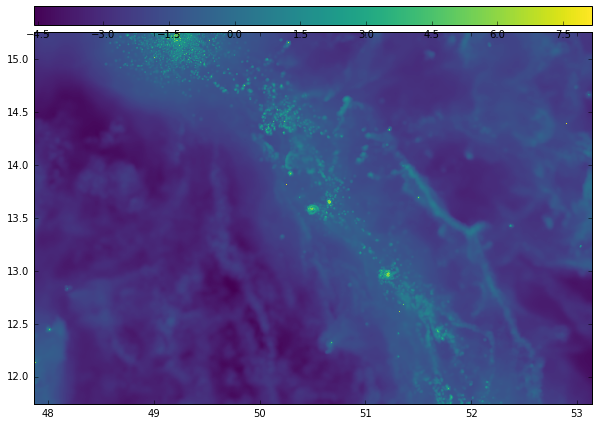

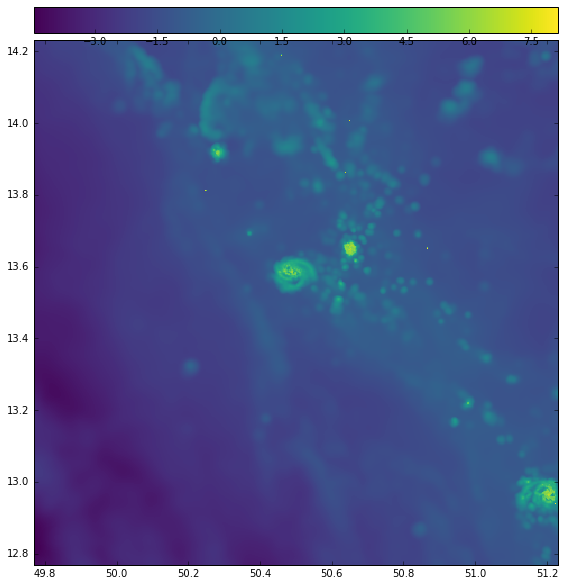

In [6]:
fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
colmap = 'viridis'
ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest')
div = axgrid.make_axes_locatable(ax)
cax = div.append_axes("top",size="5%",pad=0.1)
cbar = plt.colorbar(img, cax=cax,orientation='horizontal')

fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
colmap = 'viridis'
ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
img = ax.imshow(data_tiny.T,extent=(xystarts_tiny[0],xystarts_tiny[0]+size_tiny[0],xystarts_tiny[1],xystarts_tiny[1]+size_tiny[1]),\
                origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest')
div = axgrid.make_axes_locatable(ax)
cax = div.append_axes("top",size="5%",pad=0.1)
cbar = plt.colorbar(img, cax=cax,orientation='horizontal')

In [7]:
def getbounds(data_FOV, xystarts, size, slicewidth):
    """
    Reads in the output from extract_FOV and spits out the bounds of the cutout data in Mpc
    Also takes in the slicewidth, so that it can output bound in the z-direction
    """
    xmin = xystarts[0]; xmax = xystarts[0]+size[0]; ymin = xystarts[1]; ymax = xystarts[1]+size[1]  # Mpc
    zmin = 0.; zmax = float(slicewidth)
    # We have to add weird numbers because when I loaded the data, the simulations were out of order...
    if int(slicewidth)==5:
        zmin = zmin+10.; zmax = zmax+10.
    if int(slicewidth)==10:
        zmin = zmin+10.; zmax = zmax+10.
    if int(slicewidth)==15:
        zmin = zmin+5.; zmax = zmax+5.
        
    return xmin,xmax,ymin,ymax,zmin,zmax

xmin,xmax,ymin,ymax,zmin,zmax = getbounds(data_FOV, xystarts, size, slicewidth)
print xmin,xmax,ymin,ymax,zmin,zmax

47.8625 53.1375 11.74375 15.25625 10.0 15.0


Read in the galaxy catalogue for only galaxies inside the cutout.

In [8]:
import eagleSqlTools as sql
verbose=True
def searchgals(xmin,xmax,ymin,ymax,zmin,zmax):
    
    mySim = ('RefL0100N1504',100.)
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  

    myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x, \
                SH.CentreOfPotential_y, \
                SH.CentreOfPotential_z, \
                SH.SubGroupNumber, \
                SH.MassType_Star, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.CentreOfPotential_x >= %s and \
                SH.CentreOfPotential_x <= %s and \
                SH.CentreOfPotential_y >= %s and \
                SH.CentreOfPotential_y <= %s and \
                SH.CentreOfPotential_z >= %s and \
                SH.CentreOfPotential_z <= %s and \
                SH.MassType_Star > 0 "%('RefL0100N1504',xmin,xmax,ymin,ymax,zmin,zmax)
 

                #  and \
              #  SH.StarFormationRate > 0.00001 

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    xgal = myData['CentreOfPotential_x'][:]   # cMpc
    ygal = myData['CentreOfPotential_y'][:]   # cMpc
    #z = myData['CentreOfMass_z'][:]
    mgal = myData['MassType_Star'][:]         # M_solar
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    
    return xgal,ygal,mgal,rhgas,rhstar

xgal,ygal,mgal,rhgas,rhstar = searchgals(xmin,xmax,ymin,ymax,zmin,zmax)

SELECT                 SH.GalaxyID,                 SH.StarFormationRate as SFR,                 SH.CentreOfPotential_x,                 SH.CentreOfPotential_y,                 SH.CentreOfPotential_z,                 SH.SubGroupNumber,                 SH.MassType_Star,                 SH.HalfMassProjRad_Gas,                 SH.HalfMassProjRad_Star             FROM                 RefL0100N1504_SubHalo as SH             WHERE                 SH.SnapNum = 28 and                 SH.CentreOfPotential_x >= 47.8625 and                 SH.CentreOfPotential_x <= 53.1375 and                 SH.CentreOfPotential_y >= 11.74375 and                 SH.CentreOfPotential_y <= 15.25625 and                 SH.CentreOfPotential_z >= 10.0 and                 SH.CentreOfPotential_z <= 15.0 and                 SH.MassType_Star > 0 


Transform coordinates of galaxy catalogue into coordinate system with origin at (0,0) position of the cutout.

In [9]:
xgal_zero = xgal-xmin
ygal_zero = ygal-ymin

### Double check that the cutout and the galaxy catalogue match

Plot the cutout data and plot the locations of the galaxies on top.

5*rhstar, 36.7, is greater than 3.1245408 kpc, and has galaxy mass of 1.54698e+07, and a 5*rhgas of 225.8.
5*rhstar, 24.7, is greater than 3.1245408 kpc, and has galaxy mass of 2.08594e+07, and a 5*rhgas of 5.2.
5*rhstar, 12.6, is greater than 3.1245408 kpc, and has galaxy mass of 5.06366e+08, and a 5*rhgas of 25.1.
5*rhstar, 10.6, is greater than 3.1245408 kpc, and has galaxy mass of 2.06748e+08, and a 5*rhgas of 185.7.
5*rhstar, 12.6, is greater than 3.1245408 kpc, and has galaxy mass of 2.3184e+08, and a 5*rhgas of 5.2.
5*rhstar, 21.7, is greater than 3.1245408 kpc, and has galaxy mass of 2.49948e+08, and a 5*rhgas of 25.4.
5*rhstar, 12.9, is greater than 3.1245408 kpc, and has galaxy mass of 2.04149e+08, and a 5*rhgas of 43.5.
5*rhstar, 15.5, is greater than 3.1245408 kpc, and has galaxy mass of 1.94957e+09, and a 5*rhgas of 37.6.
5*rhstar, 17.8, is greater than 3.1245408 kpc, and has galaxy mass of 1.51175e+09, and a 5*rhgas of 14.5.
5*rhstar, 16.0, is greater than 3.1245408 kpc, 

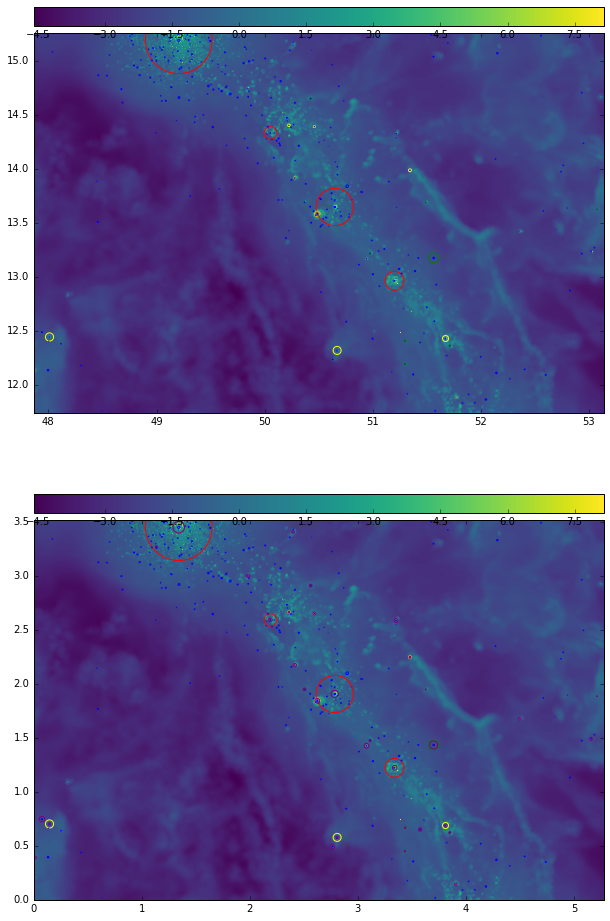

In [65]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(16, 16))
#fig, (ax1) = plt.subplots(1, 1, figsize=(16, 16))

def pltimg(data_FOV,ax,xystarts,size):
    colmap = 'viridis'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest')
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("top",size="5%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    
verbose=False

def plotgals(xgal,ygal,rhgas,rhstar,mgal,ax1):
    for i in range(len(xgal)):
        colour = 'green'
        if mgal[i]>10**8:
            colour = 'yellow'
        if mgal[i]>10**9:
            colour = 'orange'
        if mgal[i]>10**10:
            colour = 'red'
        circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhgas[i]/1000., color=colour,fill=False)
        ax1.add_artist(circle1)
        circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhstar[i]/1000., color='blue',fill=False)
        ax1.add_artist(circle1)
        if verbose:
            Mpcperpix = 0.477/1000.*(1.+0.0235) * 6.4
            if (rhstar[i]*5.) > (Mpcperpix*1000.) and (rhgas[i]*5.) > (Mpcperpix*1000.):
                print("5*rhstar, %.1f, is greater than %s kpc, and has galaxy mass of %s, and a 5*rhgas of %.1f."%\
                      ((rhstar[i]*5.),(Mpcperpix*1000.),mgal[i],(rhgas[i]*5.)))
                circle1 = plt.Circle((xgal[i],ygal[i]), radius=rhstar[i]/1000.*5., color='purple',fill=False)
                ax1.add_artist(circle1)

                
pltimg(data_FOV,ax1,xystarts,size)
plotgals(xgal,ygal,rhgas,rhstar,mgal,ax1)

verbose=True
pltimg(data_FOV,ax2,[0,0],size)
plotgals(xgal_zero,ygal_zero,rhgas,rhstar,mgal,ax2)
print resolution

Repeat the above for the tiny cutout so we have a better view of what's going on.

SELECT                 SH.GalaxyID,                 SH.StarFormationRate as SFR,                 SH.CentreOfPotential_x,                 SH.CentreOfPotential_y,                 SH.CentreOfPotential_z,                 SH.SubGroupNumber,                 SH.MassType_Star,                 SH.HalfMassProjRad_Gas,                 SH.HalfMassProjRad_Star             FROM                 RefL0100N1504_SubHalo as SH             WHERE                 SH.SnapNum = 28 and                 SH.CentreOfPotential_x >= 49.76875 and                 SH.CentreOfPotential_x <= 51.23125 and                 SH.CentreOfPotential_y >= 12.76875 and                 SH.CentreOfPotential_y <= 14.23125 and                 SH.CentreOfPotential_z >= 10.0 and                 SH.CentreOfPotential_z <= 15.0 and                 SH.MassType_Star > 0 
5*rhstar, 21.7, is greater than 3.1245408 kpc, and has galaxy mass of 2.49948e+08, and a 5*rhgas of 25.4.
5*rhstar, 15.5, is greater than 3.1245408 kpc, and has galaxy mass of

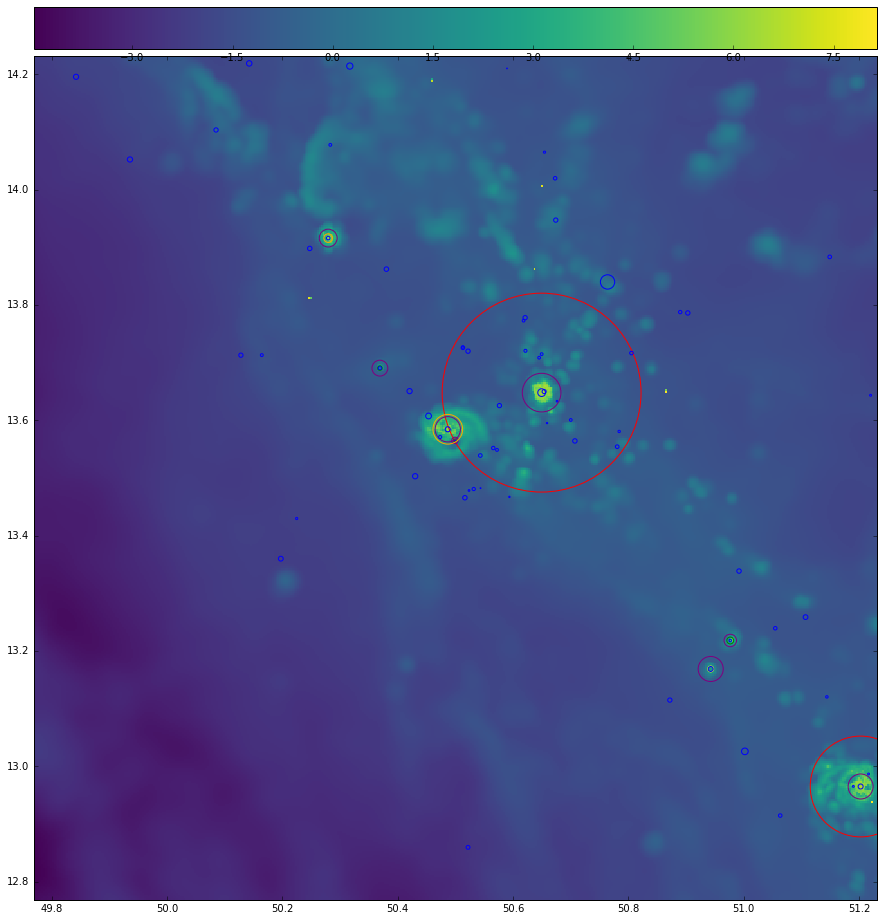

In [66]:
xmin,xmax,ymin,ymax,zmin,zmax = getbounds(data_tiny, xystarts_tiny, size_tiny, slicewidth)
xgal_tiny,ygal_tine,mgal_tiny,rhgas_tiny,rhstar_tiny = searchgals(xmin,xmax,ymin,ymax,zmin,zmax)

fig, (ax1) = plt.subplots(1, 1, figsize=(16, 16))
pltimg(data_tiny,ax1,xystarts_tiny,size_tiny)
plotgals(xgal_tiny,ygal_tine,rhgas_tiny,rhstar_tiny,mgal_tiny,ax1)


### Make a mask for the data based on the galaxy catalogue

Need to use the resolution and distance to the simulation to get the pixelscale.

In [14]:
pixscale =  {'46Mpc': 0.221/1000.*(1.+0.0107), '50Mpc': 0.237/1000.*(1.+0.0115), \
             '92Mpc': 0.437/1000.*(1.+0.0215),'100Mpc': 0.477/1000.*(1.+0.0235),\
             '200Mpc': 0.928/1000.*(1.+0.047) , '500Mpc': 2.178/1000.*(1.+0.12)} ### Mpc / arcsec (comoving)

Make a mask by using the locations of the galaxies - if they matched up with bright pixels in the above plot, then you are good to just carry on, otherwise need to debug why coordinate systems are not matching up properly.

Use the Mpc/pixel scale to decide how many pixels to bin centered on the center of the galaxy.  <br>

We just want to mask the core of the galaxy.  We have the stellar masses of the galaxies from the catalogue, and we also have the "sizes" of the galaxies.  Need to decide on the best way to mask - probably only the central pixel (since each pixel is 3kpcx3kpc which is pretty big).

In [55]:
def maskgals(xgal,ygal,rhstar,rhgas,mgal,data,xystarts,size,distance,resolution,debug=False):
    xsize = data.shape[0]; ysize = data.shape[1]
    xlen = size_tiny[0]; ylen = size_tiny[1]
    Mpcperpix = pixscale[distance]*resolution
    if debug:
        print xsize,ysize
        print xlen,ylen
        print Mpcperpix
    bordersize = 10
    mask = np.zeros((xsize+2*bordersize,ysize+2*bordersize))
    if debug:
        print mask.shape
    #xgal_tiny,ygal_tine,mgal_tiny,rhgas_tiny,rhstar_tiny
    for i in range(len(xgal)):
        xind = int(round((xgal[i]-xystarts[0])*xsize/xlen))
        yind = int(round((ygal[i]-xystarts[1])*ysize/ylen))
        xmask = xind+10; ymask = yind+10
        mask[xmask,ymask] = 1
        if (rhstar[i]*5.) > (Mpcperpix*1000.) and (rhgas[i]*5.) > (Mpcperpix*1000.):
            print("5*rhstar, %.1f, is greater than %s kpc, and has galaxy mass of %s, and a 5*rhgas of %.1f."%\
                          ((rhstar[i]*5.),(Mpcperpix*1000.),mgal[i],(rhgas[i]*5.)))
            five_rhstar = rhstar[i]*5.
            radpix = int( round( five_rhstar/(Mpcperpix*1000.) ) ) - 1 # -1 because adds center pixel
            piecemask = skimagemorphology.disk(radpix) 
            if debug:
                print piecemask.shape
                print mask[xmask-radpix:xmask+radpix+1,ymask-radpix:ymask+radpix+1].shape
                print ""
            mask[xmask-radpix:xmask+radpix+1,ymask-radpix:ymask+radpix+1] = piecemask

    mask = mask[bordersize+1:xsize+bordersize+1,bordersize+1:ysize+bordersize+1]
    if debug:
        print mask.shape

    masked_data = np.ma.masked_array(data, mask=mask)
    
    return masked_data

Test out the masking script.

In [60]:
#pltimg(data_tiny,ax1,xystarts_tiny,size_tiny)
#plotgals(xgal_tiny,ygal_tine,rhgas_tiny,rhstar_tiny,mgal_tiny,ax1)
print distance, str(resolution)+'arcsec'
masked_data = maskgals(xgal_tiny,ygal_tine,rhstar_tiny,rhgas_tiny,mgal_tiny,data_tiny,xystarts_tiny,size_tiny,distance,resolution,debug=True)


100Mpc 6.4arcsec
468 468
1.4625 1.4625
0.0031245408
(488, 488)
5*rhstar, 21.7, is greater than 3.1245408 kpc, and has galaxy mass of 2.49948e+08, and a 5*rhgas of 25.4.
(13, 13)
(13, 13)

5*rhstar, 15.5, is greater than 3.1245408 kpc, and has galaxy mass of 1.94957e+09, and a 5*rhgas of 37.6.
(9, 9)
(9, 9)

5*rhstar, 33.5, is greater than 3.1245408 kpc, and has galaxy mass of 5.85522e+10, and a 5*rhgas of 862.1.
(21, 21)
(21, 21)

5*rhstar, 5.6, is greater than 3.1245408 kpc, and has galaxy mass of 2.6323e+07, and a 5*rhgas of 12.0.
(3, 3)
(3, 3)

5*rhstar, 13.8, is greater than 3.1245408 kpc, and has galaxy mass of 2.97059e+07, and a 5*rhgas of 19.5.
(7, 7)
(7, 7)

5*rhstar, 10.8, is greater than 3.1245408 kpc, and has galaxy mass of 9.91611e+07, and a 5*rhgas of 29.7.
(5, 5)
(5, 5)

5*rhstar, 21.7, is greater than 3.1245408 kpc, and has galaxy mass of 1.97809e+10, and a 5*rhgas of 436.9.
(13, 13)
(13, 13)

5*rhstar, 21.9, is greater than 3.1245408 kpc, and has galaxy mass of 4.75481e

5*rhstar, 21.7, is greater than 3.1245408 kpc, and has galaxy mass of 2.49948e+08, and a 5*rhgas of 25.4.
5*rhstar, 15.5, is greater than 3.1245408 kpc, and has galaxy mass of 1.94957e+09, and a 5*rhgas of 37.6.
5*rhstar, 33.5, is greater than 3.1245408 kpc, and has galaxy mass of 5.85522e+10, and a 5*rhgas of 862.1.
5*rhstar, 5.6, is greater than 3.1245408 kpc, and has galaxy mass of 2.6323e+07, and a 5*rhgas of 12.0.
5*rhstar, 13.8, is greater than 3.1245408 kpc, and has galaxy mass of 2.97059e+07, and a 5*rhgas of 19.5.
5*rhstar, 10.8, is greater than 3.1245408 kpc, and has galaxy mass of 9.91611e+07, and a 5*rhgas of 29.7.
5*rhstar, 21.7, is greater than 3.1245408 kpc, and has galaxy mass of 1.97809e+10, and a 5*rhgas of 436.9.
5*rhstar, 21.9, is greater than 3.1245408 kpc, and has galaxy mass of 4.75481e+09, and a 5*rhgas of 128.6.


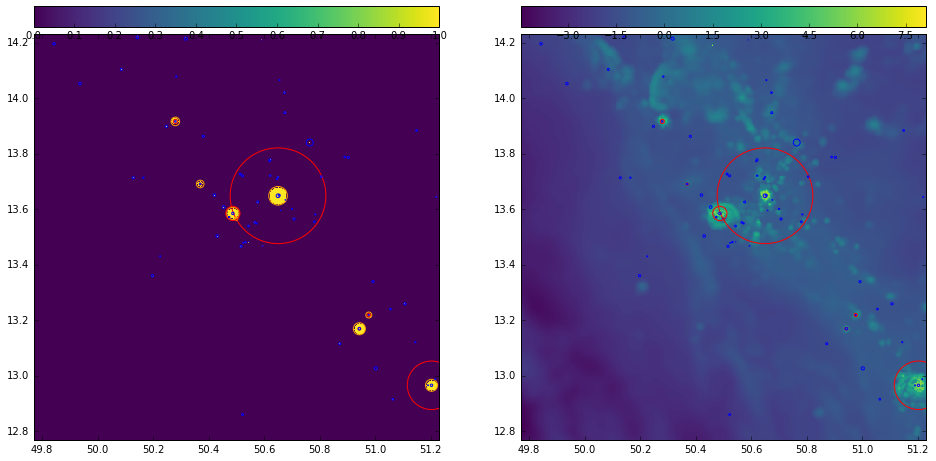

In [61]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
verbose=True
pltimg(masked_data.mask,ax1,xystarts_tiny,size_tiny)
plotgals(xgal_tiny,ygal_tine,rhgas_tiny,rhstar_tiny,mgal_tiny,ax1)
verbose=False
pltimg(masked_data.data,ax2,xystarts_tiny,size_tiny)
plotgals(xgal_tiny,ygal_tine,rhgas_tiny,rhstar_tiny,mgal_tiny,ax2)

### Return the mask with the data

In [7]:
def plotdata(data,ax=None,bounds=None,colorbar=False):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None:
        img = ax.imshow(data,origin='lower',interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()

In [59]:
def imreduce_masked(img,factor,mask=None,log=True,fillby='max'):
    """
    reduces the resolution of an image by taking the mean of individual elements
    takes in a mask to mask out values to be not included in the mean
        img: 2D image array
        mask: mask for the 2D image array
        factor: factor by which to reduce the number of array elements along each axis
        log: whether or not the array contains log data values
    examples:
    for testing: 
        image = np.array([[1,1,2,2],[1,201,2,2],[3,3,200,4],[3,3,4,4]])
    mask your mask like this:  
        clipped = sigma_clip(image,sig=3,iters=2)
        mask = clipped.mask
    """
    if log:
        inimg = 10**img
    else:
        inimg = img
    
    inshape = np.array(img.shape)
    
    if mask is None:
        clipped_full = sigma_clip(inimg,sig=3,iters=5)
        outliers =clipped_full.mask
        # grow the mask
        outliers =morphology.grey_dilation(outliers,(3,3))       # the mask
        print "the mask:"
        print outliers
        print "saving as imreduce_mask.npz..."
        np.savez('imreduce_mask.npz',outliers)
        inmask = outliers
    else:
        outliers = mask
        inmask = mask
        
    if np.sum(inshape%factor) != 0:
        print('Output grid must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None

    # split along axes into groups that will be binned
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))
    # do the same for the masks
    inmask = np.array(np.split(inmask,inshape[0]/factor,axis=0))
    inmask = np.array(np.split(inmask,inshape[1]/factor,axis=-1))
    
    # make the masked array
    x = np.ma.array(inimg, mask=inmask)
       
    # take the mean along different axes
    x = np.ma.mean(x,axis=-1)
    x = np.ma.mean(x,axis=-1)
    
    # BUT WHAT IF THERE IS ONLY MASKED DATA WITHIN A BIN...
    fillvalue=fillby
    if True in x.mask:
        print "WARNING: At least one bin contains only masked data - will be filled to %s."%fillby
        if fillby=='mean':
            x = x.filled(x.mean())
            fillvalue= x.mean()
        elif fillby=='max':
            x = x.filled(x.max())
            fillvalue=x.max()
        else:
            x = x.filled(fillvalue)
        #return x.T,outliers,fillvalue
        outimg = x
    else:
        outimg = x.data
    
    if log:
        outimg = np.log10(outimg)
    
    return outimg.T, outliers, fillvalue

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Binning the data down to about 150 arcsec scale, so using a factor of 50.0.
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ..., False False False]]


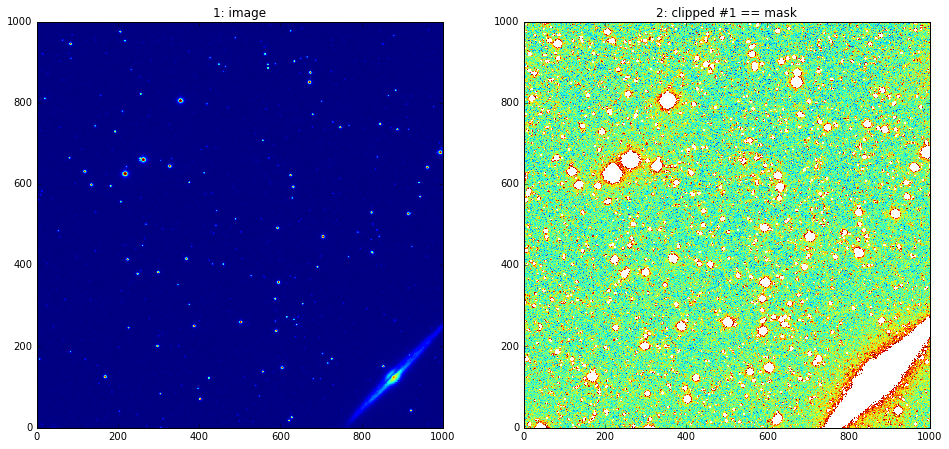

In [43]:

imagefile=homedir+'2017-04-02_coadd_SloanG.fits'
d_needle279,h_needle279 = fits.getdata(imagefile,header=True)

image = d_needle279
scale = 150 # arcsec
pixelscale = 3.0 #arcsec per pixel
factor = scale/pixelscale
img = image[40*factor:60*factor,40*factor:60*factor]     # the data

clipped_full = sigma_clip(img,sig=3,iters=5)
outliers =clipped_full.mask
# grow the mask
outliers =morphology.grey_dilation(outliers,(3,3))       # the mask
print "Binning the data down to about %s arcsec scale, so using a factor of %s." %(scale,factor)

# Plot the full res data and mask of that
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(np.log10(img),ax=ax1)
ax1.set_title('1: image')
plotdata(np.log10(clipped_full),ax=ax2)
ax2.set_title('2: clipped #1 == mask')

# Plot the binned data (wo mask) and binned data (w mask)
lowres = get_halpha_SB.imreduce(img, factor, log=False, method = 'average') 
lowres_masked, mask, fillvalue = imreduce_masked(img,factor,log=False)